In [1]:
!pip install guided-filter-pytorch

In [2]:
!git clone https://github.com/pfnet-research/FSCS.git

Cloning into 'FSCS'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 54 (delta 9), reused 54 (delta 9), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [3]:
%cd FSCS/src

/content/FSCS/src


Inference for an image

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
from torchvision.utils import save_image
from net import MaskGenerator, ResiduePredictor
from mydataset import MyDataset
import cv2
import os
import time

In [6]:
#### User inputs

run_name = 'sample'
num_primary_color = 7 
csv_path = 'sample.csv' # なんでも良い．後方でパスを置き換えるから
resize_scale_factor = 1  

# image name and palette color values
img_name = 'apple.jpg'; manual_color_0 = [253, 253, 254]; manual_color_1 = [203, 194, 170]; manual_color_2 = [83, 17, 22]; manual_color_3 = [205, 118, 4]; manual_color_4 = [220, 222, 11]; manual_color_5 = [155, 24, 10]; manual_color_6 = [171, 75, 67]; 
#img_name = 'boat.png'; manual_color_0 = [25, 21, 16]; manual_color_1 = [153, 155, 163]; manual_color_2 = [177,189,206]; manual_color_3 = [94, 89, 88]; manual_color_4 = [213, 215, 221]; manual_color_5 = [85,26,20]; manual_color_6 = [160,217,214]; 
#img_name = 'buildings.png'; manual_color_0 = [59, 66, 80]; manual_color_1 = [12, 12, 11]; manual_color_2 = [65, 56, 43]; manual_color_3 = [78, 92, 120]; manual_color_4 = [223, 192, 124]; manual_color_5 = [128, 102, 63]; manual_color_6 = [36, 36, 33]; 
#img_name = 'castle.jpg'; manual_color_0 = [60, 81, 116]; manual_color_1 = [175, 198, 215]; manual_color_2 = [0, 0, 0]; manual_color_3 = [114, 149, 185]; manual_color_4 = [142, 172, 198]; manual_color_5 = [92, 116, 149]; manual_color_6 = [226, 221, 222]; 
#img_name = 'girls.png'; manual_color_0 = [125, 116, 105]; manual_color_1 = [155, 162, 191]; manual_color_2 = [52, 60, 39]; manual_color_3 = [87, 120, 196]; manual_color_4 = [87, 107, 56]; manual_color_5 = [19, 26, 10]; manual_color_6 = [183,187,209]; 
#img_name = 'rowboat1.png'; manual_color_2 = [175, 77, 13]; manual_color_1 = [51, 45, 39]; manual_color_0 = [93, 89, 90]; manual_color_6 = [245, 141, 84]; manual_color_4 = [14, 13, 7]; manual_color_5 = [62, 71, 74]; manual_color_3 = [158,153,157]; 
#img_name = 'scrooge.png'; manual_color_0 = [254, 254, 254]; manual_color_1 = [78, 71, 65]; manual_color_2 = [211, 182, 135]; manual_color_3 = [165, 127, 100]; manual_color_4 = [40, 38, 34]; manual_color_5 = [112, 45, 31]; manual_color_6 = [177, 57, 35]; 
#img_name = 'turquoise.png'; manual_color_0 = [86, 59, 67]; manual_color_1 = [121, 132, 148]; manual_color_2 = [228, 186, 156]; manual_color_3 = [53, 35, 34]; manual_color_4 = [190, 135, 122]; manual_color_5 = [94, 152, 154]; manual_color_6 = [254,229,216]; 
#img_name = 'orange.png'; manual_color_0 = [79, 81, 59]; manual_color_1 = [112, 117, 105]; manual_color_2 = [137, 92, 41]; manual_color_3 = [201,214,197]; manual_color_4 = [42, 53, 49]; manual_color_5 = [168, 130, 40]; manual_color_6 = [114, 60, 31]; 

####

img_path = '../dataset/test/' + img_name

path_mask_generator = 'results/' + run_name + '/mask_generator.pth'
path_residue_predictor = 'results/' + run_name + '/residue_predictor.pth'

if num_primary_color == 7:
    manual_colors = np.array([manual_color_0, manual_color_1, manual_color_2, manual_color_3,\
                                               manual_color_4, manual_color_5, manual_color_6]) /255
elif num_primary_color == 6:
    manual_colors = np.array([manual_color_0, manual_color_1, manual_color_2, manual_color_3,\
                                               manual_color_4, manual_color_5]) /255

In [7]:
try:
    os.makedirs('results/%s/%s' % (run_name, img_name))
except OSError:
    pass

In [8]:
test_dataset = MyDataset(csv_path, num_primary_color, mode='test')
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    )



device = 'cuda'

# define model
mask_generator = MaskGenerator(num_primary_color).to(device)
residue_predictor = ResiduePredictor(num_primary_color).to(device)


# load params
mask_generator.load_state_dict(torch.load(path_mask_generator))
residue_predictor.load_state_dict(torch.load(path_residue_predictor))


# eval mode
mask_generator.eval()
residue_predictor.eval()

ResiduePredictor(
  (conv1): Conv2d(31, 62, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(62, 124, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(124, 248, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv1): ConvTranspose2d(248, 124, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (deconv2): ConvTranspose2d(248, 62, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (deconv3): ConvTranspose2d(124, 62, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (conv4): Conv2d(65, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(31, 21, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3

In [9]:
# 必要な関数を定義する

def replace_color(primary_color_layers, manual_colors):
    temp_primary_color_layers = primary_color_layers.clone()
    for layer in range(len(manual_colors)):
        for color in range(3):
                temp_primary_color_layers[:,layer,color,:,:].fill_(manual_colors[layer][color])
    return temp_primary_color_layers


def cut_edge(target_img):
    #print(target_img.size())
    target_img = F.interpolate(target_img, scale_factor=resize_scale_factor, mode='area')
    #print(target_img.size())
    h = target_img.size(2)
    w = target_img.size(3)
    h = h - (h % 8)
    w = w - (w % 8)
    target_img = target_img[:,:,:h,:w]
    #print(target_img.size())
    return target_img

def alpha_normalize(alpha_layers):
    # constraint (sum = 1)
    # layersの状態で受け取り，その形で返す. bn, ln, 1, h, w
    return alpha_layers / (alpha_layers.sum(dim=1, keepdim=True) + 1e-8)

def read_backimage():
    img = cv2.imread('../dataset/backimage.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.transpose((2,0,1))
    img = img/255
    img = torch.from_numpy(img.astype(np.float32))

    return img.view(1,3,256,256).to(device)

backimage = read_backimage()

In [10]:
from guided_filter_pytorch.guided_filter import GuidedFilter

def proc_guidedfilter(alpha_layers, guide_img):
    # guide_imgは， 1chのモノクロに変換
    # target_imgを使う． bn, 3, h, w
    guide_img = (guide_img[:, 0, :, :]*0.299 + guide_img[:, 1, :, :]*0.587 + guide_img[:, 2, :, :]*0.114).unsqueeze(1)
        
    # lnのそれぞれに対してguideg filterを実行
    for i in range(alpha_layers.size(1)):
        # layerは，bn, 1, h, w
        layer = alpha_layers[:, i, :, :, :]
        
        processed_layer = GuidedFilter(3, 1*1e-6)(guide_img, layer)
        # レイヤーごとの結果をまとめてlayersの形に戻す (bn, ln, 1, h, w)
        if i == 0: 
            processed_alpha_layers = processed_layer.unsqueeze(1)
        else:
            processed_alpha_layers = torch.cat((processed_alpha_layers, processed_layer.unsqueeze(1)), dim=1)
    
    return processed_alpha_layers

In [11]:
target_layer_number = [0, 1] # マスクで操作するレイヤーの番号
mask_path = 'path/to/mask.image'


## Define functions for mask operation.
# マスクを受け取る関数
# target_layer_numberが冗長なレイヤーの番号（２つ）のリスト．これらのレイヤーに操作を加える

def load_mask(mask_path):
    mask = cv2.imread(mask_path, 0) #白黒で読み込み
    mask[mask<128] = 0.
    mask[mask >= 128] = 1.
    # tensorに変換する
    mask = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).float().cuda()
    
    return mask
        

def mask_operate(alpha_layers, target_layer_number, mask_path):
    layer_A = alpha_layers[:, target_layer_number[0], :, :, :]
    layer_B = alpha_layers[:, target_layer_number[1], :, :, :]
    
    layer_AB = layer_A + layer_B
    mask = load_mask(mask_path)
    
    mask = cut_edge(mask)
    
    layer_A = layer_AB * mask
    layer_B = layer_AB * (1. - mask)
    
    return_alpha_layers = alpha_layers.clone()
    return_alpha_layers[:, target_layer_number[0], :, :, :] = layer_A
    return_alpha_layers[:, target_layer_number[1], :, :, :] = layer_B
    
    return return_alpha_layers
    

In [12]:
# datasetにある画像のパスを置き換えてしまう
test_dataset.imgs_path[0] = img_path

In [13]:
print('Start!')
img_number = 0


mean_estimation_time = 0
with torch.no_grad():
    for batch_idx, (target_img, primary_color_layers) in enumerate(test_loader):
        if batch_idx != img_number:
            print('Skip ', batch_idx)
            continue
        print('img #', batch_idx)
        target_img = cut_edge(target_img)
        target_img = target_img.to(device) # bn, 3ch, h, w
        primary_color_layers = primary_color_layers.to(device)
        #primary_color_layers = color_regresser(target_img)
        ##
        ##
        primary_color_layers = replace_color(primary_color_layers, manual_colors) #ここ
        ##
        #print(primary_color_layers.mean())
        #print(primary_color_layers.size())
        start_time = time.time()
        primary_color_pack = primary_color_layers.view(primary_color_layers.size(0), -1 , primary_color_layers.size(3), primary_color_layers.size(4))
        primary_color_pack = cut_edge(primary_color_pack)
        primary_color_layers = primary_color_pack.view(primary_color_pack.size(0),-1,3,primary_color_pack.size(2), primary_color_pack.size(3))
        pred_alpha_layers_pack = mask_generator(target_img, primary_color_pack)
        pred_alpha_layers = pred_alpha_layers_pack.view(target_img.size(0), -1, 1, target_img.size(2), target_img.size(3))
        ## Alpha Layer Proccessing
        processed_alpha_layers = alpha_normalize(pred_alpha_layers) 
        #processed_alpha_layers = mask_operate(processed_alpha_layers, target_layer_number, mask_path) # Option
        processed_alpha_layers = proc_guidedfilter(processed_alpha_layers, target_img) # Option
        processed_alpha_layers = alpha_normalize(processed_alpha_layers)  # Option
        ##
        mono_color_layers = torch.cat((primary_color_layers, processed_alpha_layers), 2) #shape: bn, ln, 4, h, w
        mono_color_layers_pack = mono_color_layers.view(target_img.size(0), -1 , target_img.size(2), target_img.size(3))
        residue_pack  = residue_predictor(target_img, mono_color_layers_pack)
        residue = residue_pack.view(target_img.size(0), -1, 3, target_img.size(2), target_img.size(3))
        pred_unmixed_rgb_layers = torch.clamp((primary_color_layers + residue), min=0., max=1.0)
        reconst_img = (pred_unmixed_rgb_layers * processed_alpha_layers).sum(dim=1)
        end_time = time.time()
        estimation_time = end_time - start_time
        print(estimation_time)
        mean_estimation_time += estimation_time
        
        if True:
            # batchsizeは１で計算されているはず．それぞれ保存する．
            save_layer_number = 0
            save_image(primary_color_layers[save_layer_number,:,:,:,:],
                   'results/%s/%s/test' % (run_name, img_name) + '_img-%02d_primary_color_layers.png' % batch_idx)
            save_image(reconst_img[save_layer_number,:,:,:].unsqueeze(0),
                   'results/%s/%s/test' % (run_name, img_name)  + '_img-%02d_reconst_img.png' % batch_idx)
            save_image(target_img[save_layer_number,:,:,:].unsqueeze(0),
                   'results/%s/%s/test' % (run_name, img_name)  + '_img-%02d_target_img.png' % batch_idx)

            # RGBAの４chのpngとして保存する
            RGBA_layers = torch.cat((pred_unmixed_rgb_layers, processed_alpha_layers), dim=2) # out: bn, ln, 4, h, w
            # test ではバッチサイズが１なので，bn部分をなくす
            RGBA_layers = RGBA_layers[0] # ln, 4. h, w
            # ln ごとに結果を保存する
            for i in range(len(RGBA_layers)):
                save_image(RGBA_layers[i, :, :, :], 'results/%s/%s/img-%02d_layer-%02d.png' % (run_name, img_name, batch_idx, i) )
            print('Saved to results/%s/%s/...' % (run_name, img_name))
            
        if False:
            ### mono_colorの分も保存する ###
            # RGBAの４chのpngとして保存する
            mono_RGBA_layers = torch.cat((primary_color_layers, processed_alpha_layers), dim=2) # out: bn, ln, 4, h, w
            # test ではバッチサイズが１なので，bn部分をなくす
            mono_RGBA_layers = mono_RGBA_layers[0] # ln, 4. h, w
            # ln ごとに結果を保存する
            for i in range(len(mono_RGBA_layers)):
                save_image(mono_RGBA_layers[i, :, :, :], 'results/%s/%s/mono_img-%02d_layer-%02d.png' % (run_name, img_name, batch_idx, i) )

            save_image((primary_color_layers * processed_alpha_layers).sum(dim=1)[save_layer_number,:,:,:].unsqueeze(0),
                   'results/%s/%s/test' % (run_name, img_name)  + '_mono_img-%02d_reconst_img.png' % batch_idx)   
        
        
        if batch_idx == 0:
            break # debug用



Start!
img # 0
0.2838418483734131
Saved to results/sample/apple.jpg/...


(Appendix) Save alpha channel and RGB channel

In [14]:
# 処理まえのアルファを保存
for i in range(len(pred_alpha_layers[0])):
            save_image(pred_alpha_layers[0,i, :, :, :], 'results/%s/%s/pred-alpha-00_layer-%02d.png' % (run_name, img_name, i) )

In [15]:
# 処理後のアルファの保存 processed_alpha_layers
for i in range(len(processed_alpha_layers[0])):
            save_image(processed_alpha_layers[0,i, :, :, :], 'results/%s/%s/proc-alpha-00_layer-%02d.png' % (run_name, img_name, i) )

In [16]:
# 処理後のRGBの保存
for i in range(len(pred_unmixed_rgb_layers[0])):
    save_image(pred_unmixed_rgb_layers[0,i, :, :, :], 'results/%s/%s/rgb-00_layer-%02d.png' % (run_name, img_name, i) )

(Appendix) K-means for culculating pallete colors

In [17]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import pandas as pd

### User inputs
num_clusters = 7
img_name = 'apple.jpg'
img_path = '../dataset/test/' + img_name

###

img = cv2.imread(img_path)[:, :, [2, 1, 0]]
size = img.shape[:2]
vec_img = img.reshape(-1, 3)
model = KMeans(n_clusters=num_clusters, n_jobs=-1)
pred = model.fit_predict(vec_img)
pred_img = np.tile(pred.reshape(*size,1), (1,1,3))

center = model.cluster_centers_.reshape(-1)
print(center)

[253.37855767 253.97747224 254.0986207   83.62911451  17.12791686
  22.35375135 203.88428928 194.00667082 168.105798   205.33776833
 118.67139033   4.80979373 171.09259146  75.56975916  66.95162768
 155.83593865  24.83270649   9.77921429 220.16923409 222.86145155
  11.31114747]


In [18]:
# Reshape for an input
print('img_name = \'%s\';' % img_name, end=" ")
for k, i in enumerate(model.cluster_centers_):
    print('manual_color_%d = [' % k + str(i[0].astype('int')) +', '+ str(i[1].astype('int'))+  ', '+ str(i[2].astype('int')) + '];', end=" ")

img_name = 'apple.jpg'; manual_color_0 = [253, 253, 254]; manual_color_1 = [83, 17, 22]; manual_color_2 = [203, 194, 168]; manual_color_3 = [205, 118, 4]; manual_color_4 = [171, 75, 66]; manual_color_5 = [155, 24, 9]; manual_color_6 = [220, 222, 11]; 

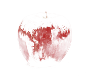

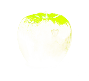

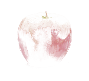

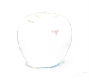

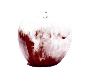

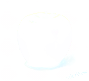

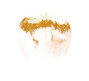

In [19]:
from google.colab.patches import cv2_imshow
import cv2
import glob

for i in glob.glob('results/sample/apple.jpg/img*.png'):
  img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
  img = cv2.resize(img , (int(img.shape[1]*0.1), int(img.shape[0]*0.1)))
  cv2_imshow(img)

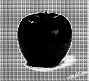

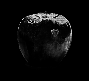

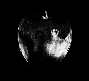

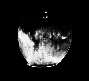

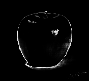

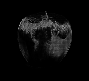

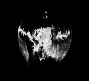

In [20]:
for i in glob.glob('results/sample/apple.jpg/pred*.png'):
  img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
  img = cv2.resize(img , (int(img.shape[1]*0.1), int(img.shape[0]*0.1)))
  cv2_imshow(img)

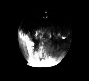

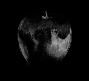

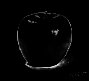

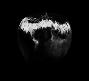

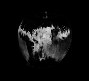

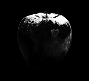

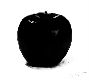

In [21]:
for i in glob.glob('results/sample/apple.jpg/proc*.png'):
  img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
  img = cv2.resize(img , (int(img.shape[1]*0.1), int(img.shape[0]*0.1)))
  cv2_imshow(img)

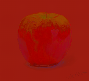

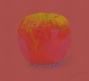

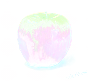

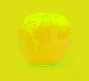

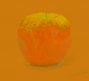

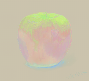

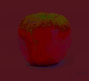

In [22]:
for i in glob.glob('results/sample/apple.jpg/rgb*.png'):
  img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
  img = cv2.resize(img , (int(img.shape[1]*0.1), int(img.shape[0]*0.1)))
  cv2_imshow(img)

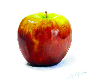

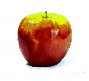

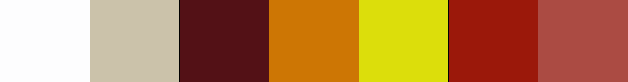

In [23]:
for i in glob.glob('results/sample/apple.jpg/test*.png'):
  img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
  img = cv2.resize(img , (int(img.shape[1]*0.1), int(img.shape[0]*0.1)))
  cv2_imshow(img)